In [1]:
import glob
import os
import numpy as np
import json
import matplotlib.pyplot as plt

In [4]:
from scipy.integrate import quad

def compute_time_rescaling_factor(potential, diffusion, sigma):
    # integrate rho(x) * D(x) dx from -inf to inf, where rho(x) = exp(- 2 * V(x) / sigma^2)
    canonical_ensemble = lambda x: np.exp(- 2* potential(x) / sigma**2)
    normalization_factor, error = quad(canonical_ensemble, -np.inf, np.inf)
    rho_times_D = lambda x: np.exp(- 2 * potential(x) / sigma**2) * diffusion(x) /  normalization_factor
    integral, error = quad(rho_times_D, -np.inf, np.inf)

    # time rescaling factor is 1 / integral
    return 1 / integral


q2Potential = lambda x: x**2 / 2
q4Potential = lambda x: x**4 / 4
softWellPotential = lambda x: x**2 / 2 +np.sin(1+3*x)
Dabs1D = lambda x: 1+ np.abs(x)
Dcosperturb1D = lambda x: 1.5 + 0.5 * np.cos(x)
Dsinperturb1D = lambda x: 1.5 + 0.5 * np.sin(x)

q2Potential_Dcosperturb1D_time_rescaling_factor = compute_time_rescaling_factor(q2Potential, Dcosperturb1D, 1)
q2Potential_Dsinperturb1D_time_rescaling_factor = compute_time_rescaling_factor(q2Potential, Dsinperturb1D, 1)
q4Potential_Dcosperturb1D_time_rescaling_factor = compute_time_rescaling_factor(q4Potential, Dcosperturb1D, 1)
q4Potential_Dsinperturb1D_time_rescaling_factor = compute_time_rescaling_factor(q4Potential, Dsinperturb1D, 1)
softWellPotential_Dabs1D_time_rescaling_factor = compute_time_rescaling_factor(softWellPotential, Dabs1D, 1)
softWellPotential_Dsin1D_time_rescaling_factor = compute_time_rescaling_factor(softWellPotential, Dsinperturb1D, 1)

print("q2Potential_Dcosperturb1D_time_rescaling_factor: ", q2Potential_Dcosperturb1D_time_rescaling_factor)
print("q2Potential_Dsinperturb1D_time_rescaling_factor: ", q2Potential_Dsinperturb1D_time_rescaling_factor)
print("q4Potential_Dcosperturb1D_time_rescaling_factor: ", q4Potential_Dcosperturb1D_time_rescaling_factor)
print("q4Potential_Dsinperturb1D_time_rescaling_factor: ", q4Potential_Dsinperturb1D_time_rescaling_factor)
print("softWellPotential_Dabs1D_time_rescaling_factor: ", softWellPotential_Dabs1D_time_rescaling_factor)
print("softWellPotential_Dsin1D_time_rescaling_factor: ", softWellPotential_Dsin1D_time_rescaling_factor)

q2Potential_Dcosperturb1D_time_rescaling_factor:  0.529268441183714
q2Potential_Dsinperturb1D_time_rescaling_factor:  0.6666666666666666
q4Potential_Dcosperturb1D_time_rescaling_factor:  0.5289782978009647
q4Potential_Dsinperturb1D_time_rescaling_factor:  0.6666666666666667
softWellPotential_Dabs1D_time_rescaling_factor:  0.5412265750831187
softWellPotential_Dsin1D_time_rescaling_factor:  0.701704010826413


In [3]:
def get_stepsizes(exp_dir):
    with open(os.path.join(exp_dir, "info.json"), "r") as f:
        info = json.load(f)
    stepsizes = info["stepsizes"]
    return stepsizes

def plot_experiments(exp_name, base_dir="./simulation_results/", offset1=1, offset2=1):
    exp_dir = os.path.join(base_dir, exp_name)
    data_files = glob.glob(os.path.join(exp_dir, "*.h5"))
    stepsizes = get_stepsizes(exp_dir)

    for data_file in data_files:
        integrator_name = os.path.splitext(os.path.basename(data_file))[0]
        if integrator_name == "euler_maruyama1D":
            stepsizes0 = stepsizes[:-2]
        else:
            stepsizes0 = stepsizes
        # load the .h5 file to a numpy array
        convergence_data = np.array(h5py.File(data_file, 'r')['data'])

        mean_convergence = np.mean(convergence_data, axis=0)
        std_convergence = np.std(convergence_data, axis=0)

        # plot the mean convergence
        plt.plot(stepsizes0, mean_convergence, label=integrator_name)
        plt.fill_between(stepsizes0, mean_convergence - std_convergence,
                        mean_convergence + std_convergence, alpha=0.3)
        
    legend = plt.legend()
    legend.get_frame().set_alpha(None)
    legend.get_frame().set_facecolor((1, 1, 1, 0.01))
    plt.ylabel("Mean L1 Error, invariant measure")
    plt.plot(stepsizes, offset1 * np.array(stepsizes), label="Gradient 1", color="black", linestyle="--", alpha=0.5)
    plt.plot(stepsizes, offset2 * np.array(stepsizes)**2, label="Gradient 2", color="black", linestyle="--", alpha=0.5)
    plt.xlabel("Stepsize, h")
    plt.yscale('log')
    plt.xscale('log')
    fig = plt.gcf()
    fig.set_size_inches(10, 7)

In [3]:
def plot_experiments2(exp_name, min_log10_stepsize=-2, base_dir="./simulation_results/", offset1=1, offset2=1, time_rescaling_factor=None, tr_trim=None, plot_dir="./plots"):
    exp_dir = os.path.join(base_dir, exp_name)
    data_files = glob.glob(os.path.join(exp_dir, "*.csv"))

    for data_file in data_files:
        integrator_name = os.path.splitext(os.path.basename(data_file))[0]
        convergence_data = np.array(np.genfromtxt(data_file, delimiter=','))
        number_of_steps, number_of_repeats = convergence_data.shape
        mean_convergence = np.mean(convergence_data, axis=1)
        std_convergence = np.std(convergence_data, axis=1)

        stepsizes = np.logspace(min_log10_stepsize, min_log10_stepsize + 0.1 * (number_of_steps-1), number_of_steps)
        if time_rescaling_factor is not None and integrator_name == "leimkuhler_matthews1D_time_rescaling":
            print("Assuming that the Leimkuhler-Matthews integrator is time rescaled, with factor: ", time_rescaling_factor)
            stepsizes = stepsizes * time_rescaling_factor
            if tr_trim is not None:
                stepsizes = stepsizes[tr_trim:]
                mean_convergence = mean_convergence[tr_trim:]
                std_convergence = std_convergence[tr_trim:]
        
        # plot the mean convergence
        plt.plot(stepsizes, mean_convergence, label=integrator_name)
        plt.fill_between(stepsizes, mean_convergence - std_convergence,
                        mean_convergence + std_convergence, alpha=0.3)
        
    stepsizes_for_guide_lines = np.logspace(min_log10_stepsize, min_log10_stepsize + 0.1 * (10-1), 10)
        
    legend = plt.legend()
    legend.get_frame().set_alpha(None)
    legend.get_frame().set_facecolor((1, 1, 1, 0.01))
    plt.ylabel("Mean L1 Error, invariant measure")
    plt.plot(stepsizes_for_guide_lines, offset1 * np.array(stepsizes_for_guide_lines), label="Gradient 1", color="black", linestyle="--", alpha=0.5)
    plt.plot(stepsizes_for_guide_lines, offset2 * np.array(stepsizes_for_guide_lines)**2, label="Gradient 2", color="black", linestyle="--", alpha=0.5)
    plt.xlabel("Stepsize, h")
    plt.yscale('log')
    plt.xscale('log')
    fig = plt.gcf()
    fig.set_size_inches(10, 7)
    #plt.savefig(os.path.join(plot_dir, exp_name + ".pdf"), bbox_inches='tight')
    #plt.savefig(os.path.join(plot_dir, exp_name + ".png"), bbox_inches='tight')

### Quadratic Well $V(x)=\frac{x^2}{2}$, Constant Diffusion $D(x)=1$

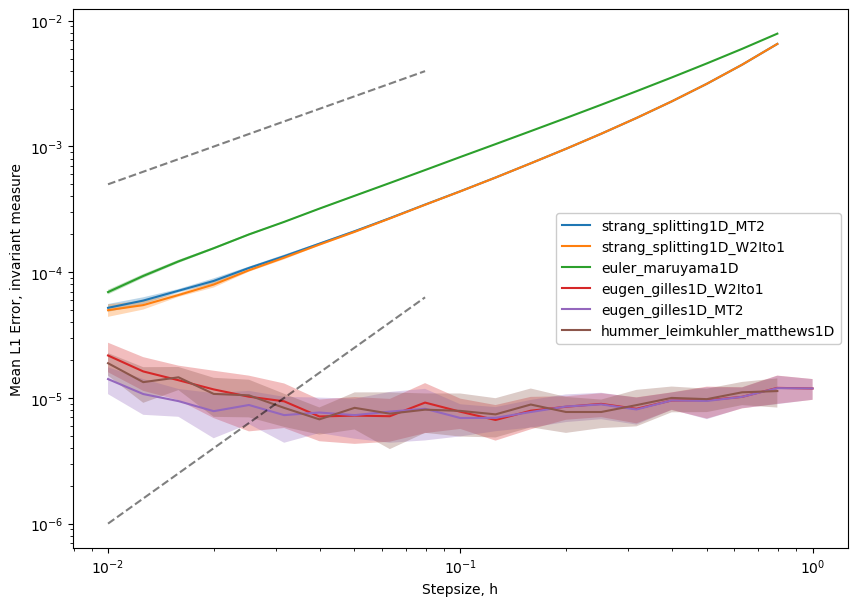

In [6]:
plot_experiments2("q2_const_1D_50M", offset1=0.05, offset2=0.01)

### Quartic Well $V(x)=\frac{x^4}{4}$, Constant Diffusion $D(x)=1$

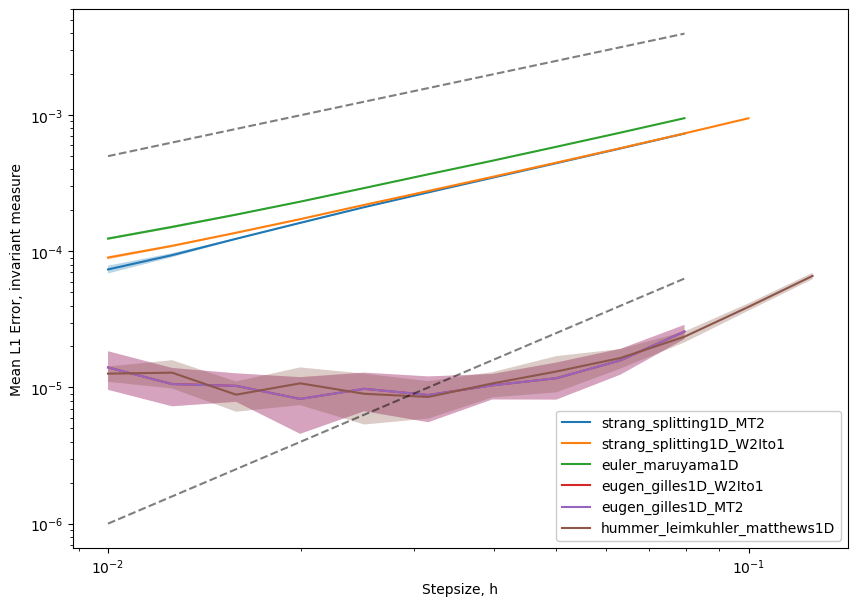

In [7]:
plot_experiments2("q4_const_1D_50M", offset1=0.05, offset2=0.01)

### Soft Well $V(x) = \frac{x^2}{2} + \sin(1+3x)$, Constant Diffusion $D(x)=1$

In [ ]:
# Double check two noise integerators

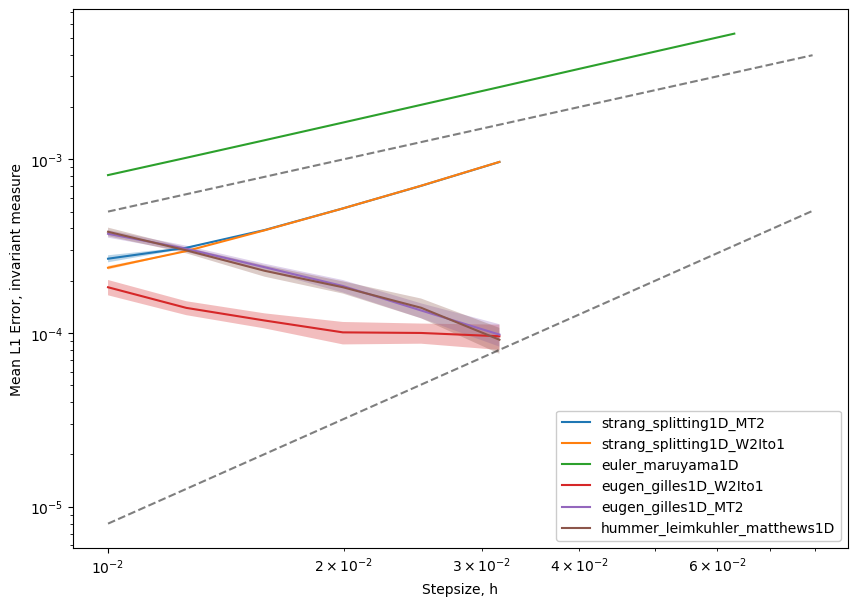

In [11]:
plot_experiments2("sw_const_1D_50M", offset1=0.05, offset2=0.08)

### Quadratic Well $V(x)=\frac{x^2}{2}$, Cosine Diffusion $D(x)=1.5 + 0.5 \cos(x)$

All except LMVD alternative runs

Assuming that the Leimkuhler-Matthews integrator is time rescaled, with factor:  0.529268441183714


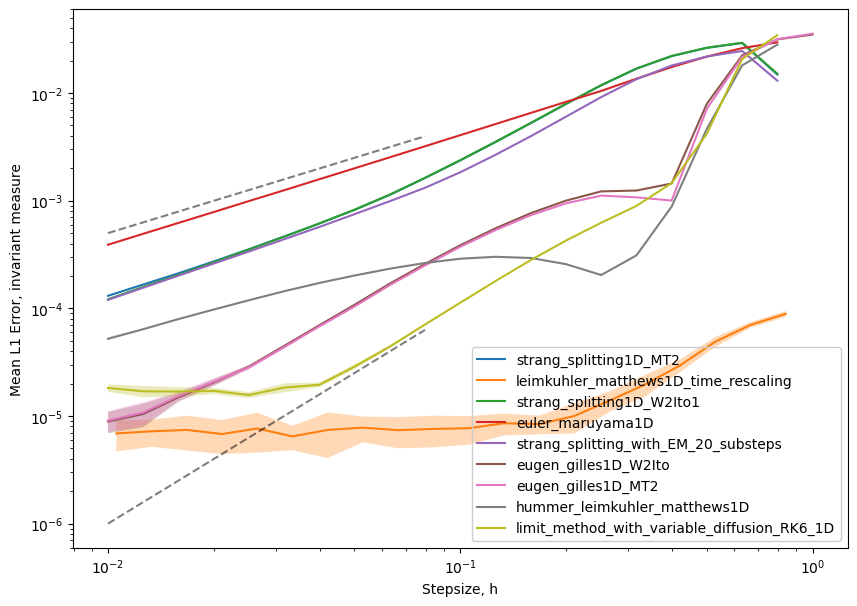

In [38]:
plot_experiments2("q2_cos_1D_50M", offset1=0.05, offset2=0.01, time_rescaling_factor=q2Potential_Dcosperturb1D_time_rescaling_factor, tr_trim=3)

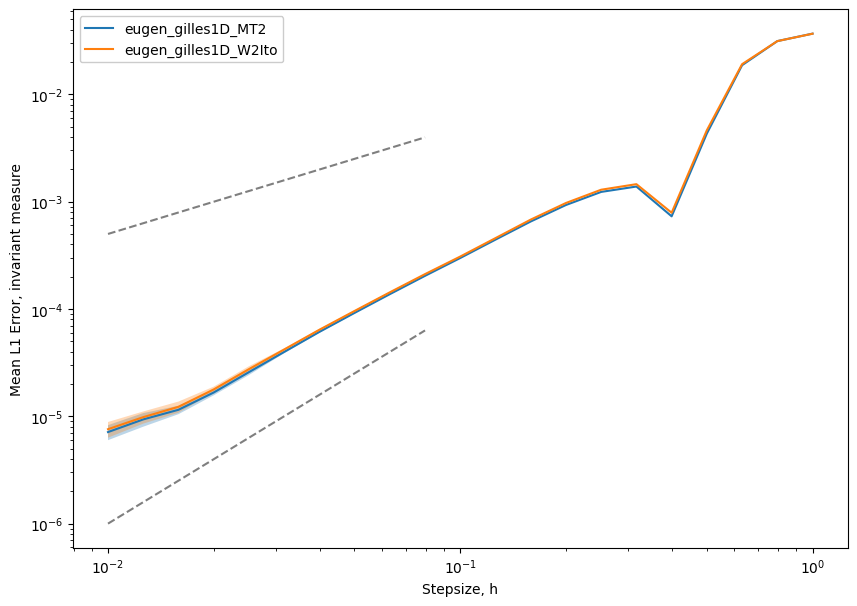

In [7]:
plot_experiments2("q2_cos_1D_50M", offset1=0.05, offset2=0.01, time_rescaling_factor=q2Potential_Dsinperturb1D_time_rescaling_factor, tr_trim=3)

### LMVD alternative runs

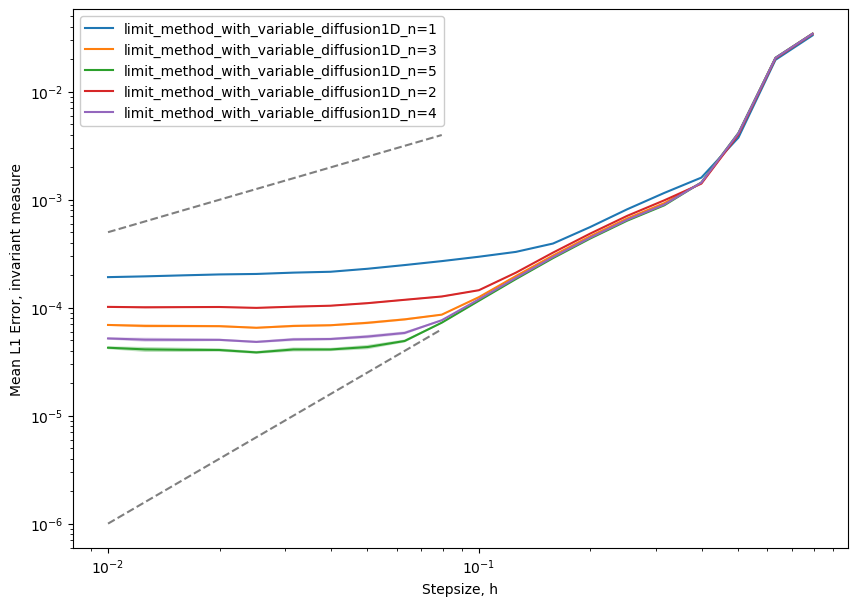

In [15]:
plot_experiments2("q2_cos_1D_LMVD_50M_RK4", offset1=0.05, offset2=0.01)

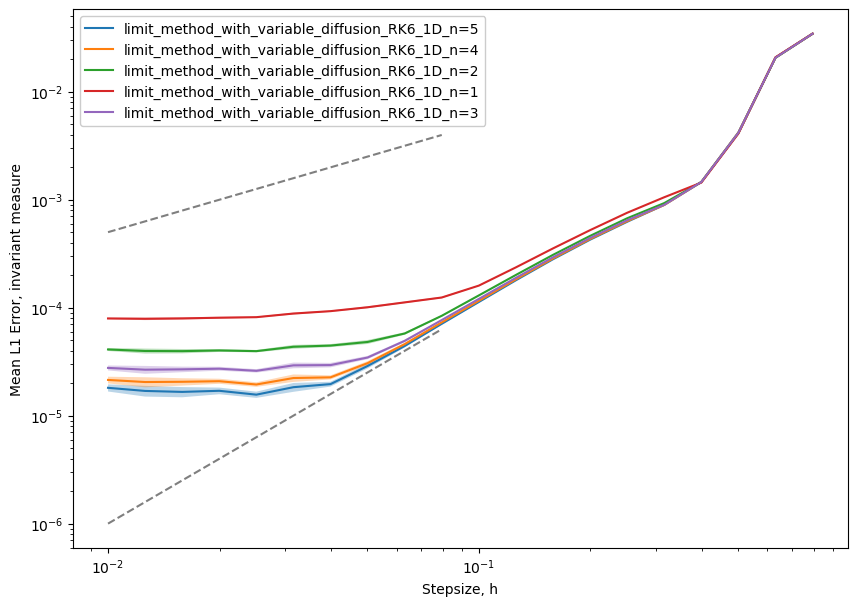

In [17]:
plot_experiments2("q2_cos_1D_LMVD_50M_RK6", offset1=0.05, offset2=0.01)

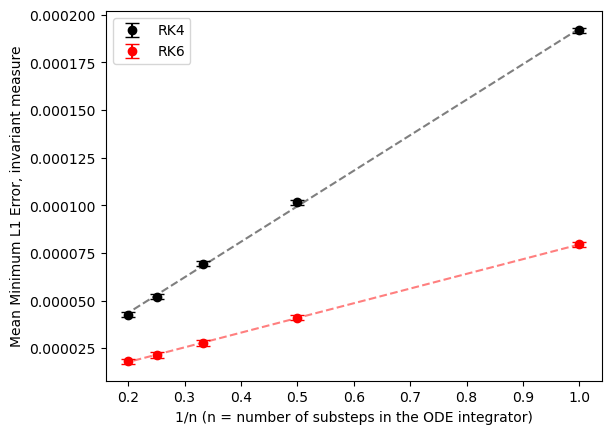

In [43]:
RK4_data = [(0.000191758594160952, 1.295985695279088e-06),(0.0001016782606131403, 1.3084182527861632e-06),(6.917154289540596e-05, 1.3059964930144861e-06),(5.1866809143875737e-05, 1.3077193409237903e-06),(4.2564602311339206e-05, 1.3029380466749965e-06)]
RK6_data = [(7.941447337873536e-05, 1.3055042717060343e-06),(4.099591832864302e-05, 1.3070711738935398e-06),(2.7670162072188106e-05, 1.4533069579538631e-06),(2.14084541970992e-05, 1.5144803757916636e-06),(1.809896294442198e-05, 1.3715572404979694e-06)]

# plot the mean and std values contained in the RK4 data
n_vals = [1/1, 1/2, 1/3, 1/4, 1/5]
RK4_mean = [x[0] for x in RK4_data]
RK4_std = [x[1] for x in RK4_data]
plt.errorbar(n_vals, RK4_mean, RK4_std, label="RK4", linestyle='None', marker='o', color='black', capsize=5)
plt.xlabel("1/n (n = number of substeps in the ODE integrator)")
plt.ylabel("Mean Minimum L1 Error, invariant measure")
# add a line of best fit
z = np.polyfit(n_vals, RK4_mean, 1)
p = np.poly1d(z)
plt.plot(n_vals, p(n_vals), color='black', linestyle='--', alpha=0.5)

RK6_mean = [x[0] for x in RK6_data]
RK6_std = [x[1] for x in RK6_data]
plt.errorbar(n_vals, RK6_mean, RK6_std, label="RK6", linestyle='None', marker='o', color='red', capsize=5)

# add a line of best fit
z = np.polyfit(n_vals, RK6_mean, 1)
p = np.poly1d(z)
plt.plot(n_vals, p(n_vals), color='red', linestyle='--', alpha=0.5)

legend = plt.legend()

### Quadratic Well $V(x)=\frac{x^2}{2}$, Sine Diffusion $D(x)=1.5 + 0.5 \sin(x)$

Assuming that the Leimkuhler-Matthews integrator is time rescaled, with factor:  0.6666666666666666


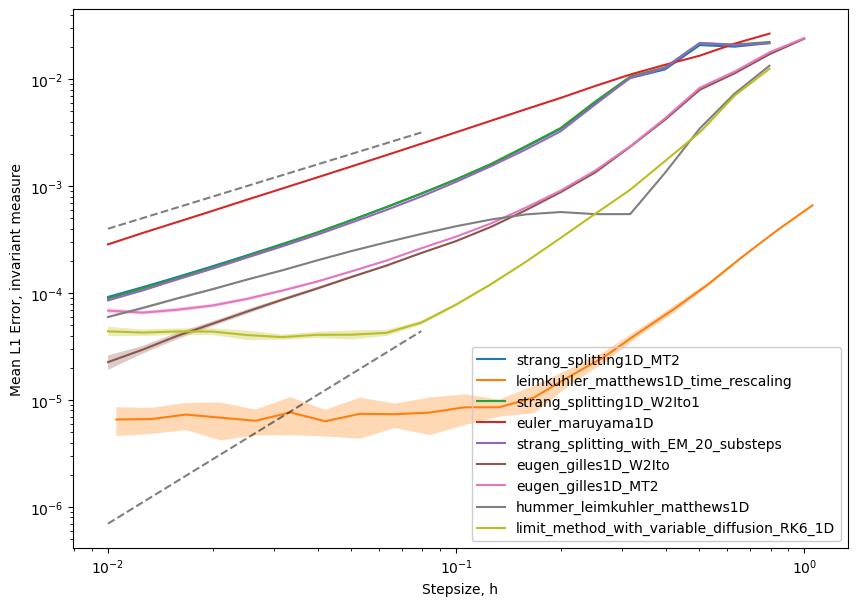

In [39]:
plot_experiments2("q2_sin_1D_50M", offset1=0.04, offset2=0.007, time_rescaling_factor=q2Potential_Dsinperturb1D_time_rescaling_factor, tr_trim=2)

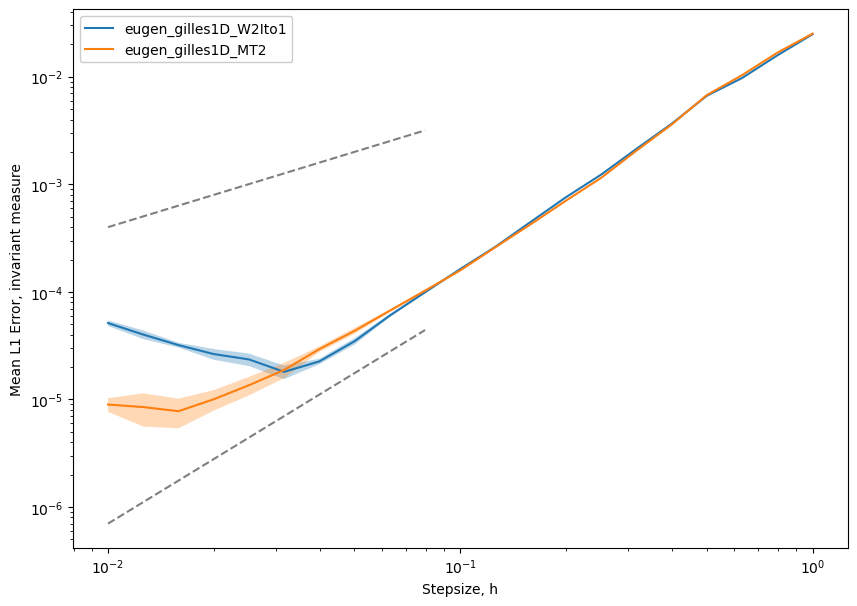

In [5]:
plot_experiments2("q2_sin_1D_50M", offset1=0.04, offset2=0.007, time_rescaling_factor=q2Potential_Dcosperturb1D_time_rescaling_factor, tr_trim=2)

### Quartic Well $V(x)=\frac{x^4}{4}$, Cosine Diffusion $D(x)=1.5 + 0.5 \cos(x)$

Assuming that the Leimkuhler-Matthews integrator is time rescaled, with factor:  0.5289782978009646


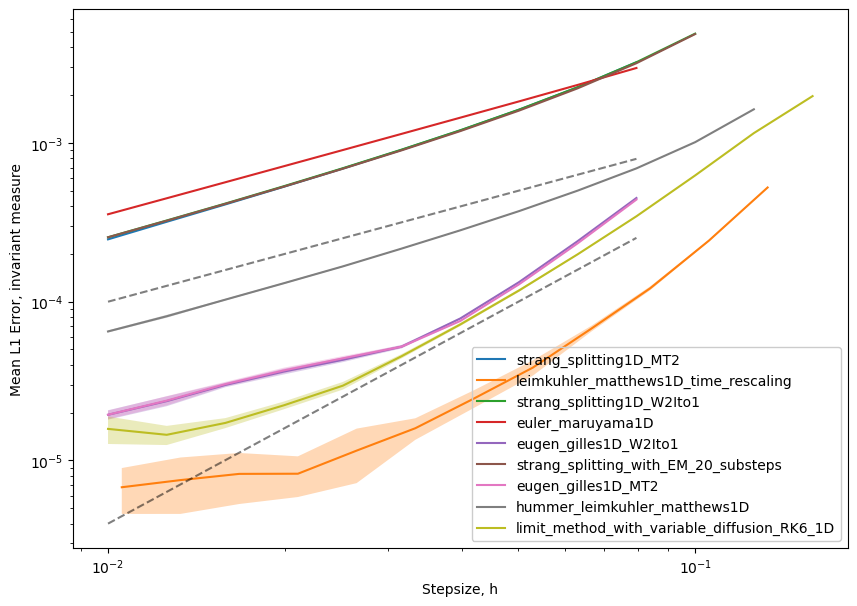

In [55]:
plot_experiments2("q4_cos_1D_50M", offset1=0.01, offset2=0.04, time_rescaling_factor=q4Potential_Dcosperturb1D_time_rescaling_factor, tr_trim=3)

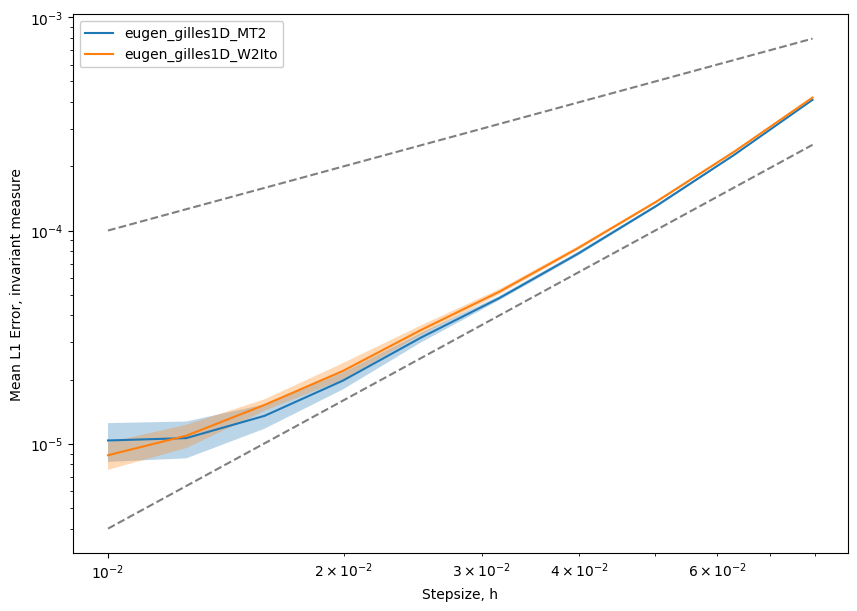

In [9]:
plot_experiments2("q4_cos_1D_50M", offset1=0.01, offset2=0.04, time_rescaling_factor=q4Potential_Dcosperturb1D_time_rescaling_factor, tr_trim=3)

### Quartic Well $V(x)=\frac{x^4}{4}$, Sine Diffusion $D(x)=1.5 + 0.5 \sin(x)$

Assuming that the Leimkuhler-Matthews integrator is time rescaled, with factor:  0.6666666666666667


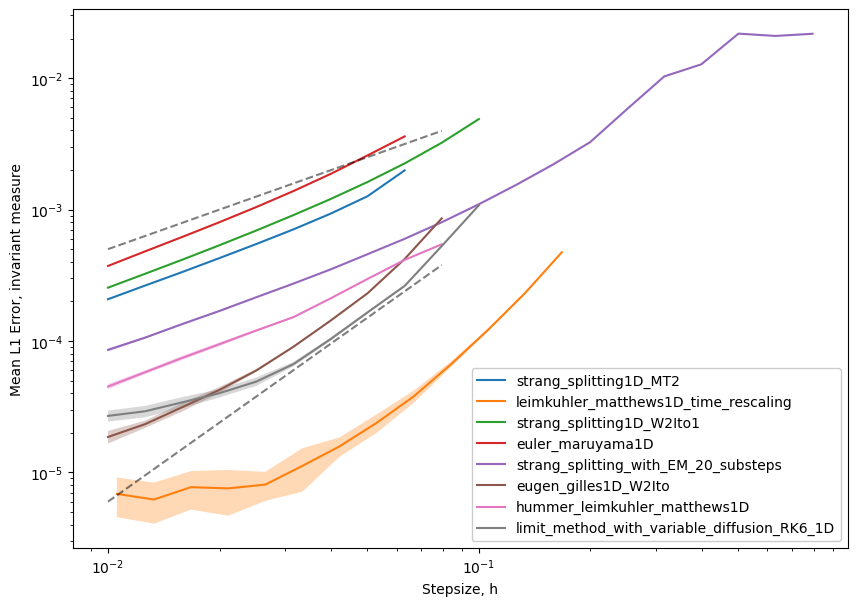

In [54]:
plot_experiments2("q4_sin_1D_50M", offset1=0.05, offset2=0.06, time_rescaling_factor=q4Potential_Dsinperturb1D_time_rescaling_factor, tr_trim=2)

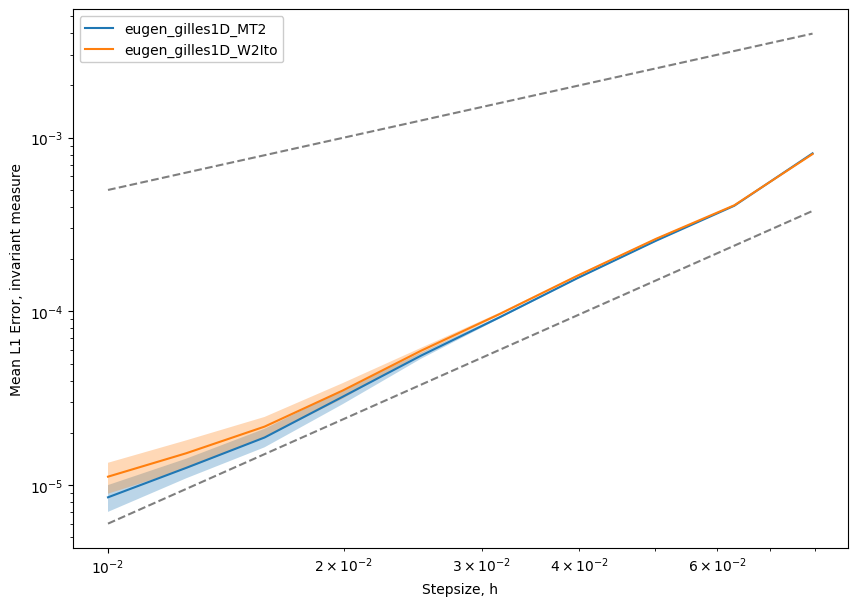

In [10]:
plot_experiments2("q4_sin_1D_50M", offset1=0.05, offset2=0.06, time_rescaling_factor=q4Potential_Dsinperturb1D_time_rescaling_factor, tr_trim=2)

### Soft Well $V(x)=\frac{x^2}{2} + \sin(1+3x)$,    $D(x)=1 + |x|$

Assuming that the Leimkuhler-Matthews integrator is time rescaled, with factor:  0.5412265750831187


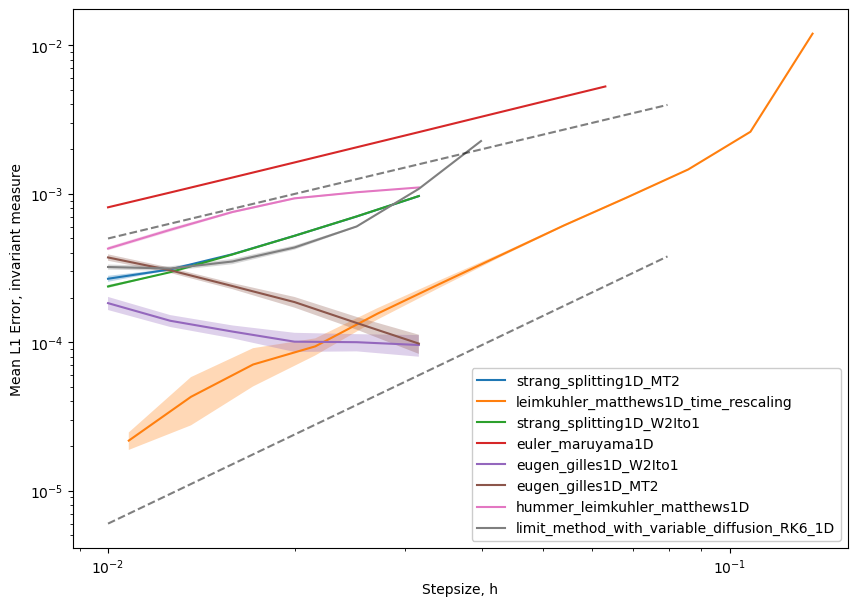

In [51]:
plot_experiments2("sw_abs_1D_50M", offset1=0.05, offset2=0.06, time_rescaling_factor=softWellPotential_Dabs1D_time_rescaling_factor, tr_trim=3)

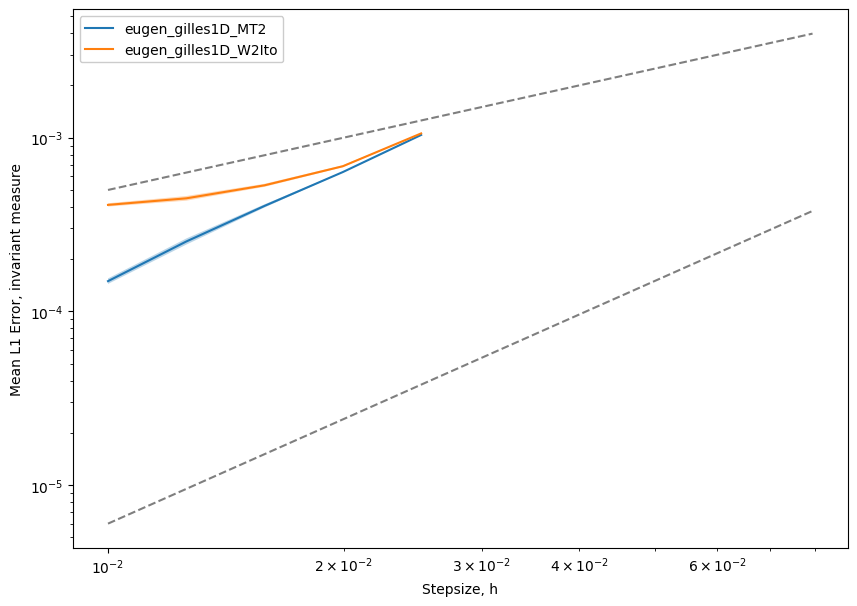

In [11]:
plot_experiments2("sw_abs_1D_50M", offset1=0.05, offset2=0.06, time_rescaling_factor=softWellPotential_Dabs1D_time_rescaling_factor, tr_trim=3)

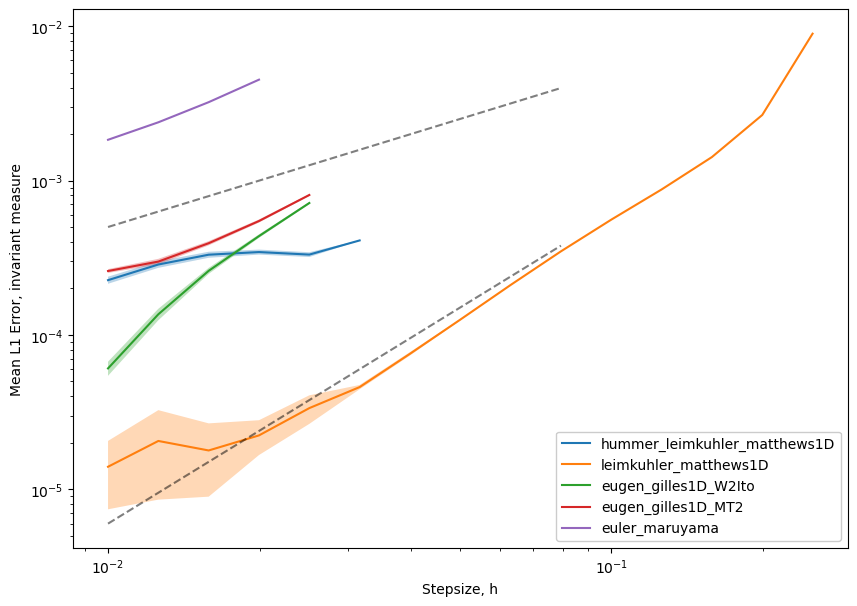

In [5]:
plot_experiments2("softWell_Dsin1D", offset1=0.05, offset2=0.06, time_rescaling_factor=softWellPotential_Dsin1D_time_rescaling_factor, tr_trim=3)

In [3]:
def plot_times(exp_name, base_dir="./simulation_results/"):
    # open times.json
    exp_dir = os.path.join(base_dir, exp_name)
    with open(os.path.join(exp_dir, "times.json"), "r") as f:
        times = json.load(f)

    # plot the times
    plt.bar(times.keys(), [value/10**9 for value in times.values()])
    plt.ylabel("Time (s)")
    plt.xlabel("Integrator")
    plt.xticks(rotation=90)
    plt.show()

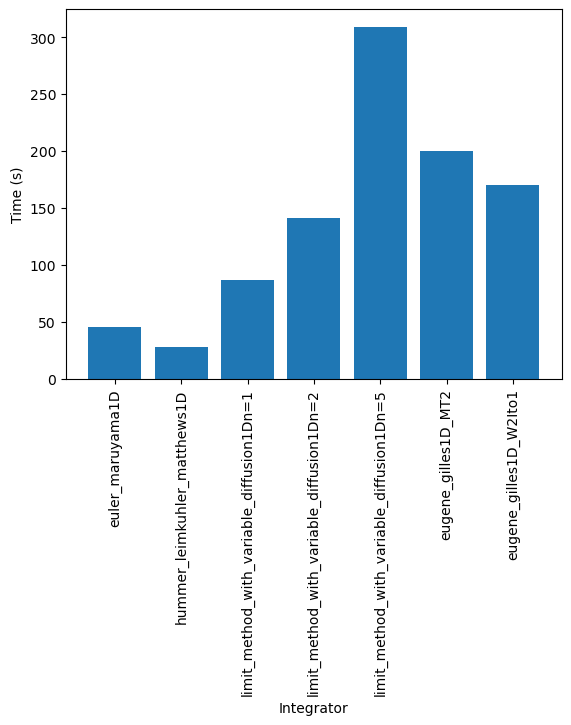

In [27]:
plot_times("quartic_cos_noise_1M")
# Note: the euler_maruyama1D integrator time includes the cost of compiling, so is an overestimate.

### QuadWell 2D with Isotropic (Moro-Cardin) diffusion

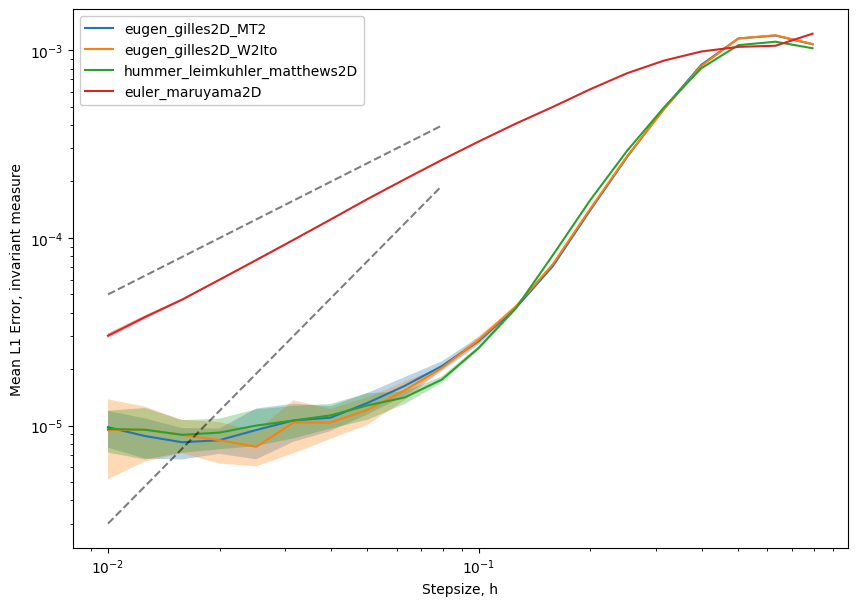

In [12]:
plot_experiments2("qw_morocardin_2D_500K", offset1=0.005, offset2= 0.03)

### QuadWell 2D with Anisotropic I Diffusion

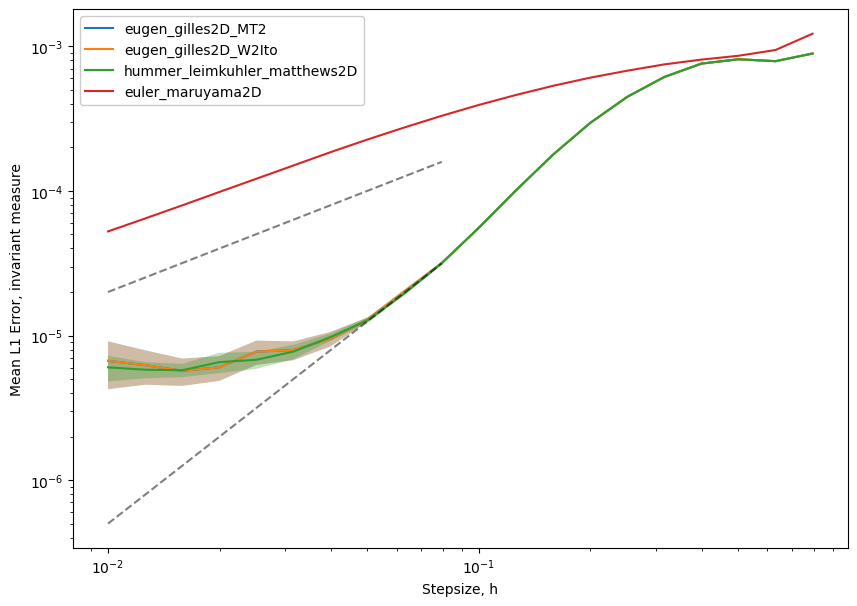

In [9]:
plot_experiments2("qw_anisotropicI_500K", offset1=0.002, offset2=0.005)

### QuadWell 2D with Anisotropic II Diffusion

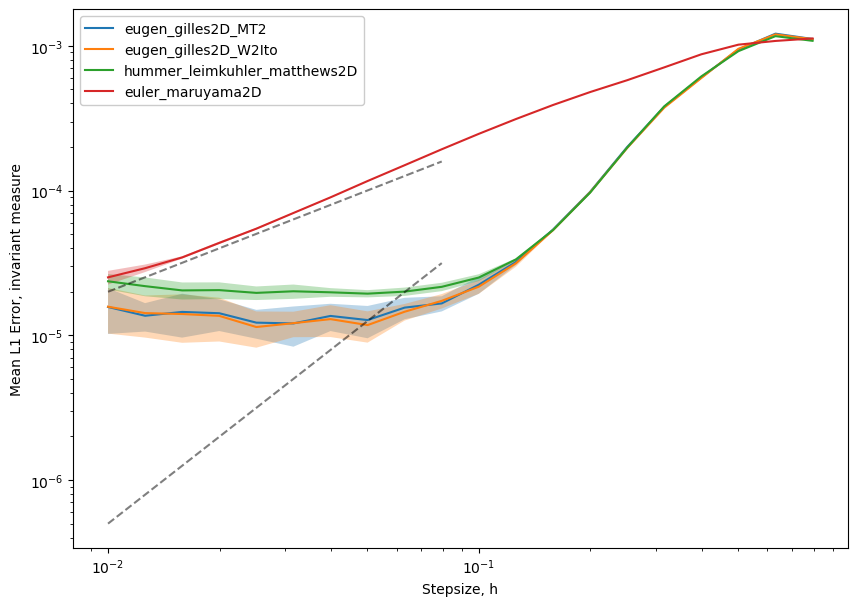

In [12]:
plot_experiments2("qw_anisotropicII_500K", offset1=0.002, offset2=0.005)

### QuadWell 2D with Anisotropic III Diffusion

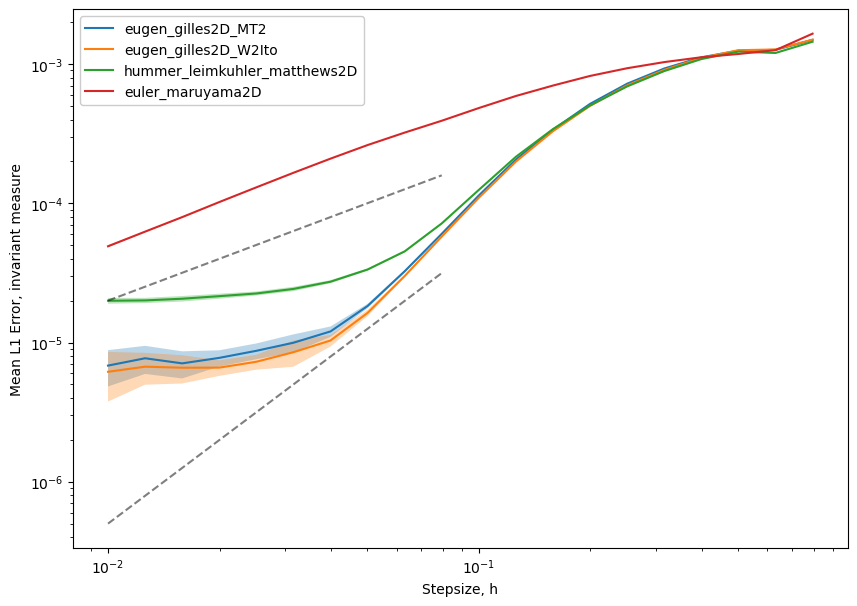

In [13]:
plot_experiments2("qw_anisotropicIII_500K", offset1=0.002, offset2=0.005)

### DoubleWell Channel with Anisotropic I Diffusion

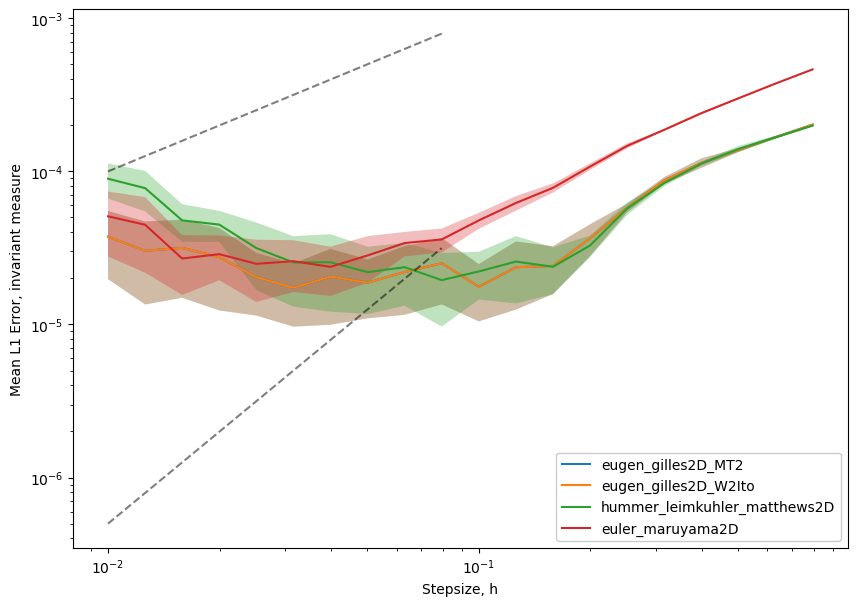

In [16]:
plot_experiments2("dw_anisotropicI_50K", offset1 = 0.01, offset2 = 0.005)

### DoubleWell Channel with Anisotropic II Diffusion

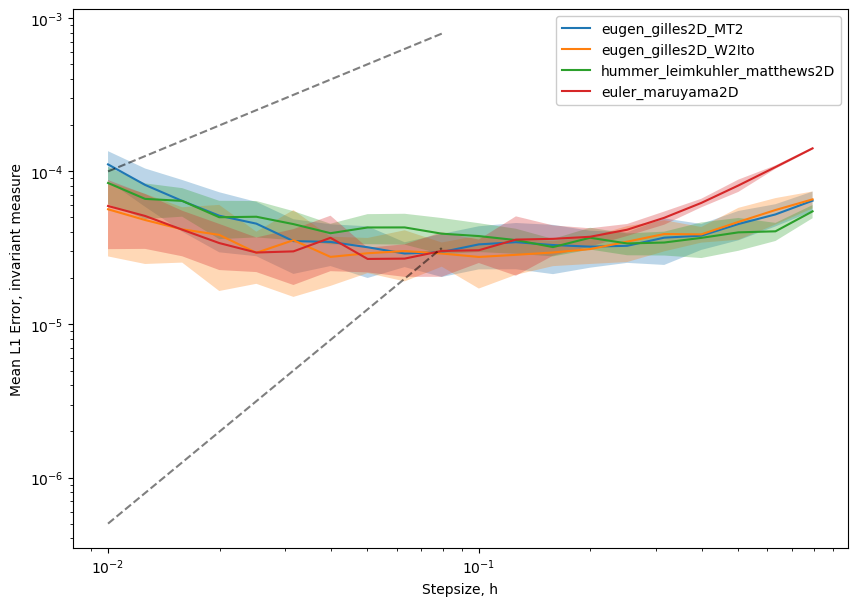

In [18]:
plot_experiments2("dw_anisotropicII_50K", offset1 = 0.01, offset2 = 0.005)

### DoubleWell Channel with Anisotropic III Diffusion

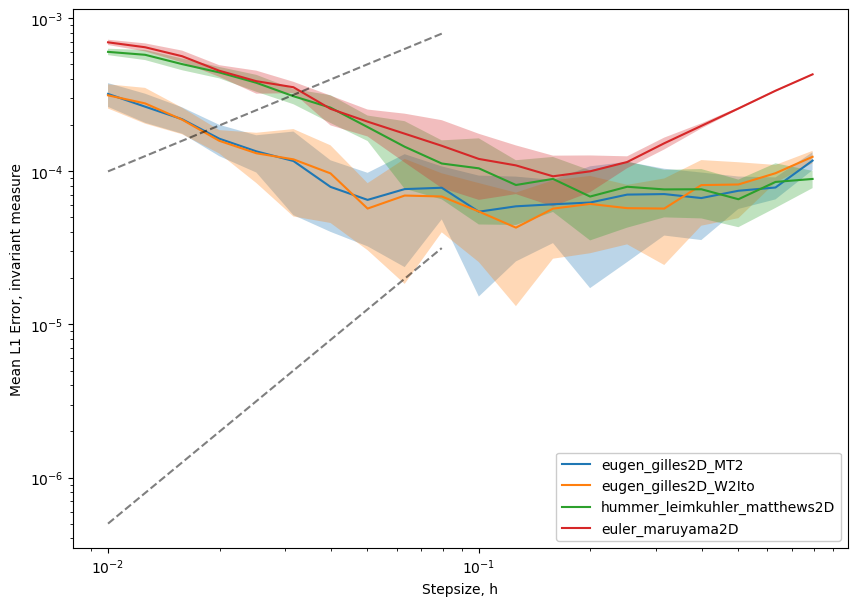

In [17]:
plot_experiments2("dw_anisotropicIII_50K", offset1 = 0.01, offset2 = 0.005)

### DoubleWell Channel with Anisotropic IV Diffusion

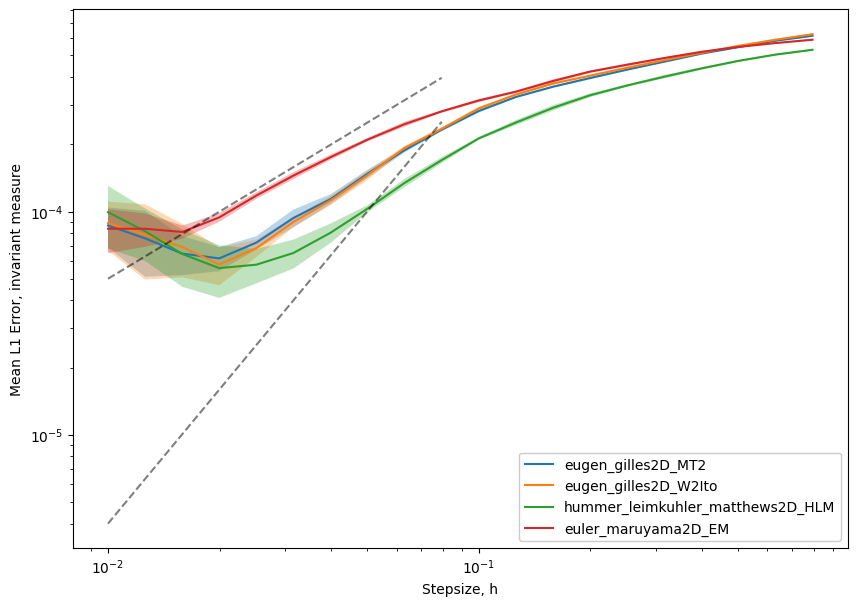

In [16]:
plot_experiments2("dw_anisotropic_2D_50K", offset1=0.005, offset2= 0.04)

Different stability thresholds $D(x)$ const vs non-const.

Get to the bottom of the stability differences for the noise integrators.

Get to the bottom of why anisotropic diffusion caused problems with the order of convergence.

Exps to run:
- Double well channel with const diffusion
- Double well channel with non-const, isotropic diffusion
- Quadruple well with anisotropic diffusion